<center>
<h1><b>Information Theory</b></h1>
<h3>Lab 7: Lossless compression – LZW algorithm</h3>
<h4>Maksymilian Norkiewicz 160267</h4>
<h4>Lecturer: Iwo Błądek<h4>
</center>

# Libraries

In [39]:
from bitarray import bitarray
import matplotlib.pyplot as plt
import os
import cv2
import math
from typing import Tuple

# LempelZivWelch class

In [78]:
class LempelZivWelch:
    @staticmethod
    def encode(input_bitarray:bitarray) -> Tuple[bitarray, int]:
        assert isinstance(input_bitarray, bitarray), "input_bitarray must be a bitarray type"

        dictionary = {bitarray([0]).to01(): 0, bitarray([1]).to01(): 1}
        current_code = 2
        result = []
        
        w = bitarray()
        for bit in input_bitarray:
            w.append(bit)
            if w.to01() not in dictionary:
                result.append(dictionary[w[:-1].to01()])
                dictionary[w.to01()] = current_code
                current_code += 1
                w = bitarray([bit])
        
        if w:
            result.append(dictionary[w.to01()])
        
        max_code = max(result)
        bit_width = max(1, math.ceil(math.log2(max_code + 1)))
        output_bitarray = bitarray()
        for index in result:
            output_bitarray.extend(format(index, f'0{bit_width}b'))
        
        return output_bitarray, bit_width


    @staticmethod
    def encode_file(file_path:str, encoded_file_path:str):
        input_bitarray = bitarray()
        with open(file_path, 'rb') as f:
            input_bitarray.fromfile(f)

        output_bitarray, bit_width = LempelZivWelch.encode(input_bitarray)

        # Add bit_width to bitarray
        bit_width = bitarray(format(bit_width, '08b'))
        output_bitarray = bit_width + output_bitarray

        # Add padding to bitarray
        padding = 8 - (len(output_bitarray) % 8)
        padding = 0 if padding == 8 else padding
        padding = bitarray(format(padding, '08b'))
        output_bitarray = padding + output_bitarray

        with open(encoded_file_path, 'wb') as f:
            output_bitarray.tofile(f)


    @staticmethod
    def decode(input_bitarray:bitarray, bit_width:int) -> bitarray:
        assert isinstance(input_bitarray, bitarray), "input_bitarray must be a bitarray type"
        assert isinstance(bit_width, int), "bit_width must be an int type"
        assert bit_width >= 1, "bit_width must be greater or equal to 1"

        dictionary = {0: bitarray([0]), 1: bitarray([1])}
        current_code = 2

        result = []
        for i in range(0, len(input_bitarray), bit_width):
            code_bits = input_bitarray[i:i + bit_width]
            if len(code_bits) < bit_width:
                break
            code = int(code_bits.to01(), 2)
            result.append(code)

        decoded_bitarray = bitarray()
        prev_entry = dictionary[result[0]]
        decoded_bitarray.extend(prev_entry)
        
        for code in result[1:]:
            if code in dictionary:
                entry = dictionary[code]
            elif code == current_code:
                entry = prev_entry + prev_entry[:1]
            else:
                raise ValueError("Invalid LZW encoding")
            
            decoded_bitarray.extend(entry)
            
            dictionary[current_code] = prev_entry + entry[:1]
            current_code += 1
            
            prev_entry = entry
        
        return decoded_bitarray


    @staticmethod
    def decode_file(encoded_file_path:str, decoded_file_path:str):
        input_bitarray = bitarray()
        with open(encoded_file_path, 'rb') as f:
            input_bitarray.fromfile(f)

        # Read padding and remove unnecessary bits
        padding = input_bitarray[:8]
        padding = int(padding.to01(), 2)
        input_bitarray = input_bitarray[8:-padding]
        input_bitarray = input_bitarray[8:]

        # Read bit_with
        bit_with = input_bitarray[:8]
        bit_with = int(bit_with.to01(), 2)
        input_bitarray = input_bitarray[8:]

        output_bitarray = LempelZivWelch.decode(input_bitarray, bit_with)

        with open(decoded_file_path, 'wb') as f:
            output_bitarray.tofile(f)

# Encoding

In [79]:
def compare_size(first_file, second_file):
    print("{} size: {:,} bytes\n{} size: {:,} bytes".format(
        first_file.split("/")[-1],
        os.path.getsize(first_file),
        second_file.split('/')[-1],
        os.path.getsize(second_file)
    ).replace(",", "\'"))

### Text files

In [80]:
original_file_path = "./data/norm_wiki_sample.txt"
encoded_file_path = "./data/norm_wiki_sample_encoded.bin"

LempelZivWelch.encode_file(original_file_path, encoded_file_path)

compare_size(original_file_path, encoded_file_path)

norm_wiki_sample.txt size: 10'788'941 bytes
norm_wiki_sample_encoded.bin size: 6'685'846 bytes


In [54]:
original_file_path = "./data/wiki_sample.txt"
encoded_file_path = "./data/wiki_sample_encoded.bin"

LempelZivWelch.encode_file(original_file_path, encoded_file_path)

compare_size(original_file_path, encoded_file_path)

wiki_sample.txt size: 11'909'016 bytes
wiki_sample_encoded.bin size: 7'568'269 bytes


### Image files

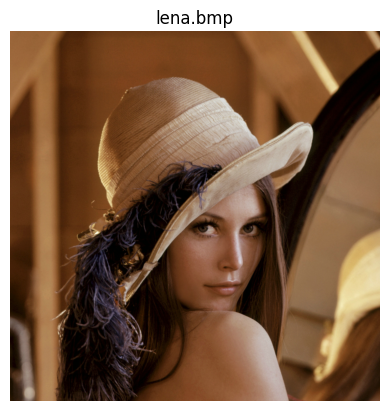

In [55]:
img = cv2.imread("./data/lena.bmp")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis(False)
plt.title("lena.bmp")
plt.show()

In [56]:
original_file_path = "./data/lena.bmp"
encoded_file_path = "./data/lena_encoded.bin"

LempelZivWelch.encode_file(original_file_path, encoded_file_path)

compare_size(original_file_path, encoded_file_path)

lena.bmp size: 11'524'938 bytes
lena_encoded.bin size: 10'774'084 bytes


# Decoding

In [84]:
def compare_files(first_file, second_file):
    return open(first_file, "rb").read() == open(second_file, "rb").read()

### Text files

In [ ]:
encoded_file_path = "./data/norm_wiki_sample_encoded.bin"
decoded_file_path = "./data/ignore/norm_wiki_sample_decoded.txt"
original_file_path = "./data/norm_wiki_sample.txt"

LempelZivWelch.decode_file(encoded_file_path, decoded_file_path)
compare_files(original_file_path, decoded_file_path)

True

In [86]:
encoded_file_path = "./data/wiki_sample_encoded.bin"
decoded_file_path = "./data/ignore/wiki_sample_decoded.txt"
original_file_path = "./data/wiki_sample.txt"

LempelZivWelch.decode_file(encoded_file_path, decoded_file_path)
compare_files(original_file_path, decoded_file_path)

True

### Image files

In [87]:
encoded_file_path = "./data/lena_encoded.bin"
decoded_file_path = "./data/ignore/lena_decoded.bmp"
original_file_path = "./data/lena.bmp"

LempelZivWelch.decode_file(encoded_file_path, decoded_file_path)
compare_files(original_file_path, decoded_file_path)

True